In [1]:
from io import StringIO

import matplotlib.pyplot as plt
from scipy.io import arff
import seaborn as sns
from loguru import logger
import yaml

from datetime import datetime
import polars as pl
import pandas as pd
import numpy as np
import sys
import os
from pathlib import Path
sys.path.append(str(Path.cwd().parent))

# MODEL
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import (
    LabelEncoder, 
    StandardScaler,
    label_binarize
)
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    accuracy_score,
    precision_recall_fscore_support,
    balanced_accuracy_score,
    roc_auc_score,
    roc_curve
)

# Save variables for model
import joblib

# PERSONAL FUNCTIONS
from utils import *
from models.main import *
from functions.windows import create_feature_windows # creación de ventanas e ingenieria de características

In [164]:
import json
with open(r'F:\UPC\Tesis\HARbit-Model\src\data\typing.json', 'rb') as file:
    data = json.load(file)

gyro_df = data['gyro']
accel_df = data['accel']

In [165]:
target = "Type"

In [166]:
accel_temp = pl.DataFrame(accel_df)
gyro_temp = pl.DataFrame(gyro_df)

In [167]:
accel_temp   = accel_temp.with_columns(pl.lit('A').alias('Usuario'))
gyro_temp    = gyro_temp.with_columns(pl.lit('A').alias('Usuario'))

In [168]:
accel_temp   = accel_temp.with_columns(pl.lit(target).alias('gt'))
gyro_temp    = gyro_temp.with_columns(pl.lit(target).alias('gt'))

In [169]:
df_accel = normalize_columns(accel_temp,
                            user_col_name  = "Usuario", 
                            timestamp_col_name = "timestamp", 
                            label_col_name = "gt", 
                            x_col_name = "x", 
                            y_col_name = "y", 
                            z_col_name = "z")

df_gyro = normalize_columns(gyro_temp, 
                            user_col_name  = "Usuario", 
                            timestamp_col_name = "timestamp", 
                            label_col_name = "gt", 
                            x_col_name = "x", 
                            y_col_name = "y", 
                            z_col_name = "z")

In [170]:
df_accel = convert_timestamp(df_accel)
df_gyro = convert_timestamp(df_gyro)

In [171]:
df_all_sensors = df_gyro.join(df_accel, on = ['Subject-id', 'Timestamp', 'Activity Label'], how = "inner")

In [172]:
df_gyro = df_all_sensors.select(
    pl.col('Subject-id'),
    pl.col('Timestamp'),
    pl.col('Activity Label'),
    pl.col('X'),
    pl.col('Y'),
    pl.col('Z')
)

df_accel = df_all_sensors.select(
    pl.col('Subject-id'),
    pl.col('Timestamp'),
    pl.col('Activity Label'),
    pl.col('X_right').alias('X'),
    pl.col('Y_right').alias('Y'),
    pl.col('Z_right').alias('Z')
)

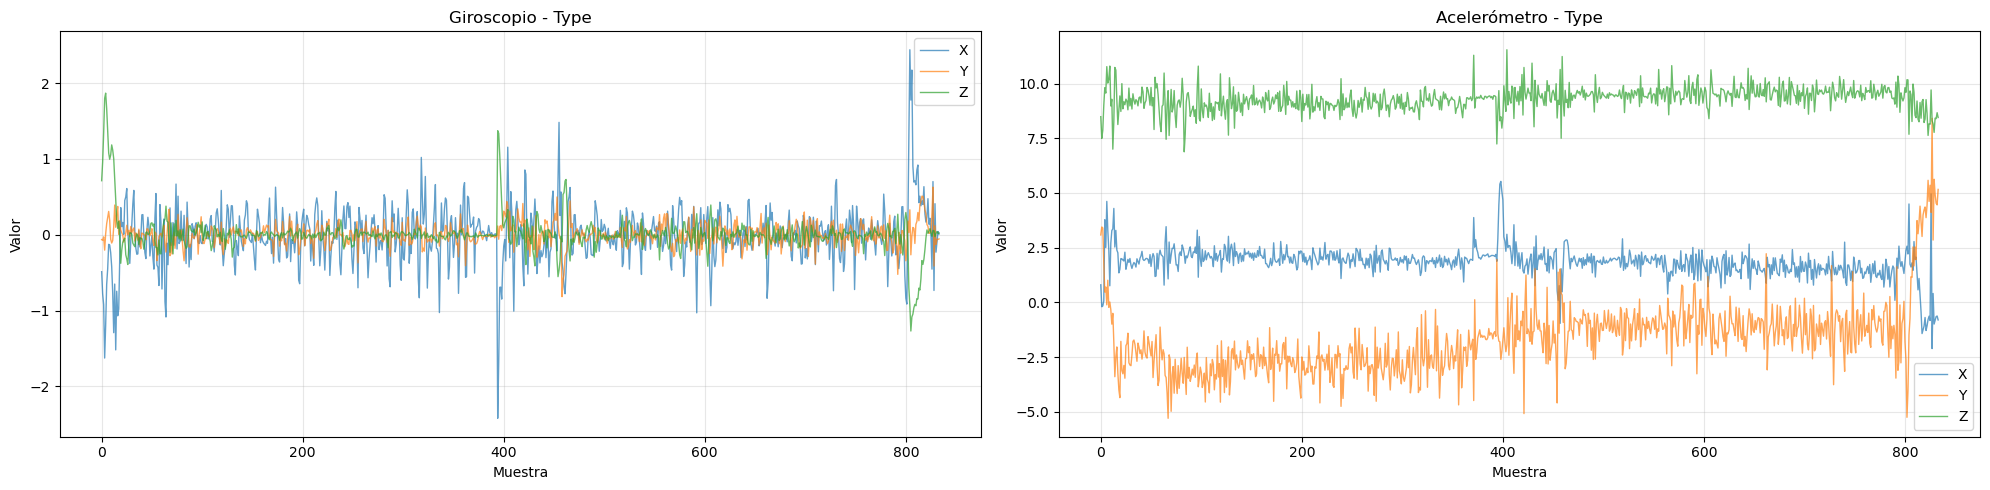

In [173]:
def plot_axes_by_activity(df_gyro, df_accel, max_samples_per_activity=1000, figsize=(15, 12)):
    """
    Visualiza los ejes X, Y, Z del giroscopio y acelerómetro por cada actividad
    """
    # Obtener actividades únicas
    activities = df_gyro['Activity Label'].unique().tolist()
    n_activities = len(activities)
    
    # Crear subplots
    fig, axes = plt.subplots(n_activities, 2, figsize=figsize)
    if n_activities == 1:
        axes = axes.reshape(1, -1)
    
    for i, activity in enumerate(activities):
        # Filtrar datos por actividad
        gyro_activity = df_gyro[df_gyro['Activity Label'] == activity]
        accel_activity =  df_accel[df_accel['Activity Label'] == activity]
        
        # Limitar muestras para mejor visualización
        if len(gyro_activity) > max_samples_per_activity:
            gyro_activity = gyro_activity.head(max_samples_per_activity)
        if len(accel_activity) > max_samples_per_activity:
            accel_activity = accel_activity.head(max_samples_per_activity)
        
        # Convertir a pandas para plotting
        gyro_pd = gyro_activity.copy()
        accel_pd = accel_activity.copy()
        
        # Plot Giroscopio
        axes[i, 0].plot(gyro_pd['X'], label='X', alpha=0.7, linewidth=1)
        axes[i, 0].plot(gyro_pd['Y'], label='Y', alpha=0.7, linewidth=1)
        axes[i, 0].plot(gyro_pd['Z'], label='Z', alpha=0.7, linewidth=1)
        axes[i, 0].set_title(f'Giroscopio - {activity}')
        axes[i, 0].set_ylabel('Valor')
        axes[i, 0].legend()
        axes[i, 0].grid(True, alpha=0.3)
        
        # Plot Acelerómetro
        axes[i, 1].plot(accel_pd['X'], label='X', alpha=0.7, linewidth=1)
        axes[i, 1].plot(accel_pd['Y'], label='Y', alpha=0.7, linewidth=1)
        axes[i, 1].plot(accel_pd['Z'], label='Z', alpha=0.7, linewidth=1)
        axes[i, 1].set_title(f'Acelerómetro - {activity}')
        axes[i, 1].set_ylabel('Valor')
        axes[i, 1].legend()
        axes[i, 1].grid(True, alpha=0.3)
        
        # Añadir xlabel solo en la última fila
        if i == n_activities - 1:
            axes[i, 0].set_xlabel('Muestra')
            axes[i, 1].set_xlabel('Muestra')
    
    plt.tight_layout()
    plt.show()

# Ejecutar visualización
plot_axes_by_activity(df_gyro.to_pandas(), df_accel.to_pandas(), figsize = (20, 5))

In [140]:
features_gyro   = create_feature_windows(df_gyro, window_seconds = 5, overlap_percent=50, sampling_rate = 20)
features_accel  = create_feature_windows(df_accel, window_seconds = 5, overlap_percent=50, sampling_rate = 20)

In [141]:
features_combined = pd.merge(
    features_gyro,
    features_accel, 
    on=['Subject-id', 'Activity Label', 'window_start', 'window_end', 'sample_count'], 
    how="inner"
)

In [142]:
X, y, _, le = prepare_features_for_cnn_lstm_sequences(
    features_combined, 
    group_size=8, 
    step_size=1
)

print(f"Forma de X (secuencias): {X.shape}")   # (N, group_size, features)
print(f"Forma de y: {y.shape}")
print(f"Actividades únicas: {np.unique(y)}")

✅ Secuencias creadas: (5, 8, 136)
  Num features: 136
  Clases: ['Type']
Forma de X (secuencias): (5, 8, 136)
Forma de y: (5,)
Actividades únicas: [0]


In [143]:
y = le.inverse_transform(y)

In [144]:
from tensorflow import keras

model = keras.models.load_model(r'F:\UPC\Tesis\HARbit-Model\src\models\cnn-lstm_wisdm_har_model_97_cluster_user.h5')
label_encoder = joblib.load(r'F:\UPC\Tesis\HARbit-Model\src\models\meta\le_wisdm_cnn_lstm_97_cluster_user.joblib')

In [145]:
y = label_encoder.transform(y)

In [146]:
print("Evaluando modelo...")
# Predicciones
y_pred = model.predict(X)
y_pred_classes = np.argmax(y_pred, axis=1)

# Obtener las clases que realmente existen en este conjunto de datos
unique_classes = np.unique(y)

# Calcular accuracy SOLO en esas clases
mask = np.isin(y, unique_classes)
filtered_accuracy = accuracy_score(y[mask], y_pred_classes[mask])

print(f"✅ Accuracy filtrado (solo clases presentes en el dataset): {filtered_accuracy:.4f}")


# Métricas básicas
test_loss, test_accuracy = model.evaluate(X, y, verbose=0)
print(f"\nPérdida en test: {test_loss:.4f}")
print(f"Precisión en test: {test_accuracy:.4f}")

# Reporte de clasificación detallado
print("\n" + "="*50)
print("REPORTE DE CLASIFICACIÓN")
print("="*50)
print(classification_report(
    y, 
    y_pred_classes, 
    labels=unique_classes,               # solo las clases presentes
    target_names=label_encoder.classes_[unique_classes],
    digits=4
))


Evaluando modelo...


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 697ms/step
✅ Accuracy filtrado (solo clases presentes en el dataset): 0.0000

Pérdida en test: 13.3766
Precisión en test: 0.0000

REPORTE DE CLASIFICACIÓN
              precision    recall  f1-score   support

        Type     0.0000    0.0000    0.0000       5.0

   micro avg     0.0000    0.0000    0.0000       5.0
   macro avg     0.0000    0.0000    0.0000       5.0
weighted avg     0.0000    0.0000    0.0000       5.0



c:\Users\HP\miniconda3\envs\forecasting\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\HP\miniconda3\envs\forecasting\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\HP\miniconda3\envs\forecasting\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\HP\minicon

In [147]:
y_pred_classes

array([5, 2, 5, 5, 0], dtype=int64)

In [148]:
label_encoder.classes_

array(['Eat', 'Others', 'Sit', 'Stand', 'Type', 'Walk', 'Workouts',
       'Write'], dtype='<U8')

In [149]:
label_encoder.classes_[unique_classes]

array(['Type'], dtype='<U8')